**Fallos en dia 3 5 y 6 df raros**

In [86]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import math
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def showPlot(df):
    runways = gpd.read_file("./puntosespera/runways.geojson")
    taxiways = gpd.read_file("./puntosespera/taxiways.geojson")
    holding_points = gpd.read_file("./puntosespera/holding_points.geojson")

    fig, ax = plt.subplots(figsize=(8, 8))

    runways.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1, alpha=0.9, zorder=1, label='Pistas')
    taxiways.plot(ax=ax, color='dodgerblue', linewidth=1, alpha=0.7, zorder=2, label='Calles de rodaje')
    holding_points.plot( ax=ax, marker='o', markersize=50, facecolor='none', edgecolor='limegreen', linewidth=1.5, alpha=0.8, zorder=3, label='Puntos de espera')
    scatter = ax.scatter(df['lon'], df['lat'], c=df['altitude'], cmap='viridis', alpha=0.7, s=10, edgecolors='none', zorder=4, label='Aviones')
    ax.scatter(-3.5300000, 40.5100278, s=250, marker='*', color='red', edgecolor='black', linewidth=1, zorder=5, label='Antena ADS-B')

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Altitud (pies)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    #x.set_xlim(-3.60, -3.50)
    #x.set_ylim(40.45, 40.55)
    ax.set_title("Mapa completo del aeropuerto de Barajas con tráfico aéreo", fontsize=18, pad=25)
    ax.set_xlabel("Longitud (lon)", fontsize=14)
    ax.set_ylabel("Latitud (lat)", fontsize=14)
    ax.grid(alpha=0.3, linestyle=':', color='gray')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

In [88]:
def create_metrics_flights(df):
    cols, dicts = ["diff", "altitude_diff", "altitude", "vertical_rate", "speed", "angle"], []
    for (icao, flight_id), group in df.groupby(["icao", "flight_id"], observed=True):
        group = group.sort_values("ts").copy()
        group["diff"] = group["ts"].diff().dt.total_seconds()
        group["altitude_diff"] = group["altitude"].diff()
        stats = { "icao":      icao,  "flight_id": flight_id,  "n_total":   len(group) }
        for col in cols:
            desc = group[col].describe()
            stats[f"{col}_mean"] = desc["mean"]
            stats[f"{col}_min"]  = desc["min"]
            stats[f"{col}_25%"]  = desc["25%"]
            stats[f"{col}_50%"]  = desc["50%"]
            stats[f"{col}_75%"]  = desc["75%"]
            stats[f"{col}_max"]  = desc["max"]
            stats[f"{col}_sum"]  = group[col].sum()
        dicts.append(stats)
    return pd.DataFrame(dicts)

def get_outliers(metrics):
    metric_cols = [c for c in metrics.columns  if c not in ("icao", "flight_id")  and pd.api.types.is_numeric_dtype(metrics[c])]
    outliers = []
    for col in metric_cols:
        s = metrics[col].dropna()
        if s.empty:
            continue
        Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        for idx in metrics[(metrics[col] < lower) | (metrics[col] > upper)].index:
            outliers.append({ "icao": metrics.at[idx, "icao"], "flight_id": metrics.at[idx, "flight_id"], "column": col, "value": metrics.at[idx, col],
                             "mean": metrics[col].mean(), "min": metrics[col].min(), "max": metrics[col].max(),
                             "50%": metrics[col].median(), "25%": metrics[col].quantile(0.25), "75%": metrics[col].quantile(0.75) })
    return pd.DataFrame(outliers)

def show_distribution(df):
    metrics = create_metrics_flights(df)
    outliers = get_outliers(metrics)
    num_columns = metrics.select_dtypes(include='number').columns
    n_cols = 6
    n_rows = math.ceil(len(num_columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12), constrained_layout=True)
    axes = axes.flatten()
    j = 0
    for col in num_columns:
        if col in outliers["column"].unique():
            data = metrics[col].dropna().reset_index(drop=True)
            axes[j].scatter(data.index, data.values, s=10, alpha=0.8)
            axes[j].set_title(col, fontsize=8)
            axes[j].tick_params(labelsize=6)
            axes[j].grid(True)
            j += 1
    for k in range(j, len(axes)):
        fig.delaxes(axes[k])
    plt.show()

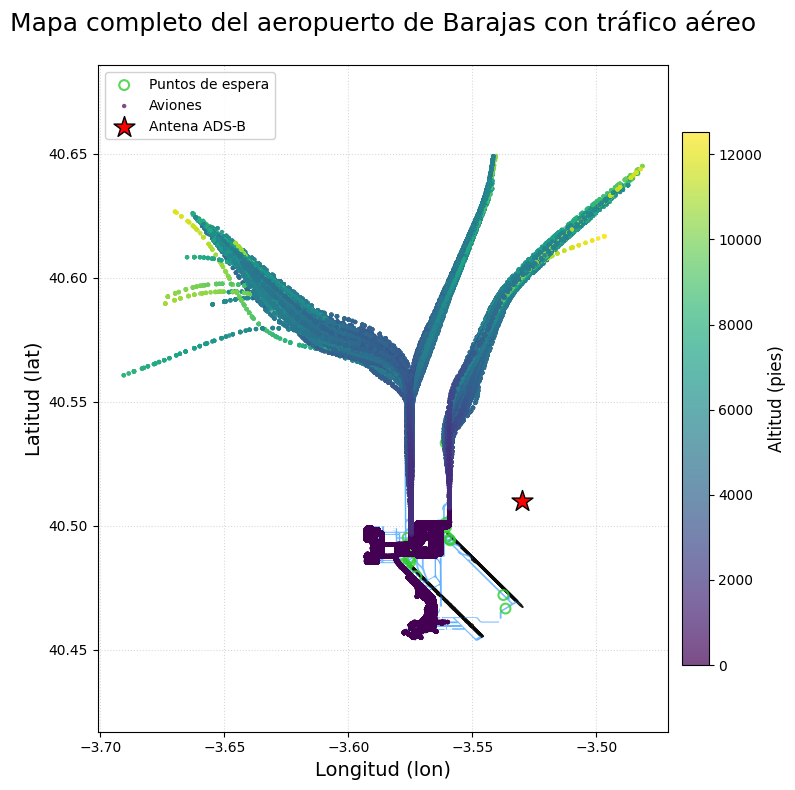

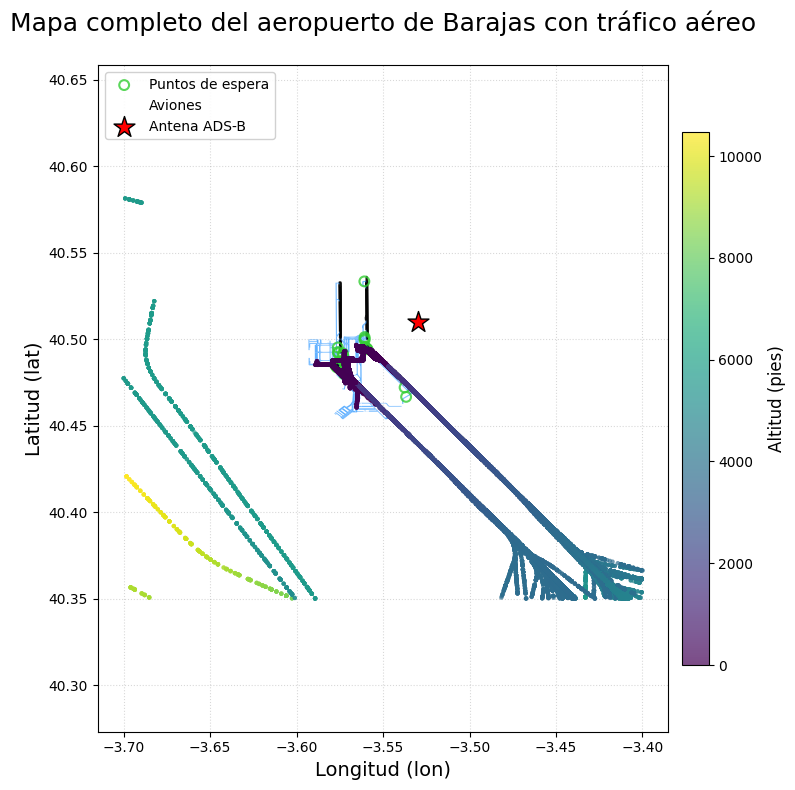

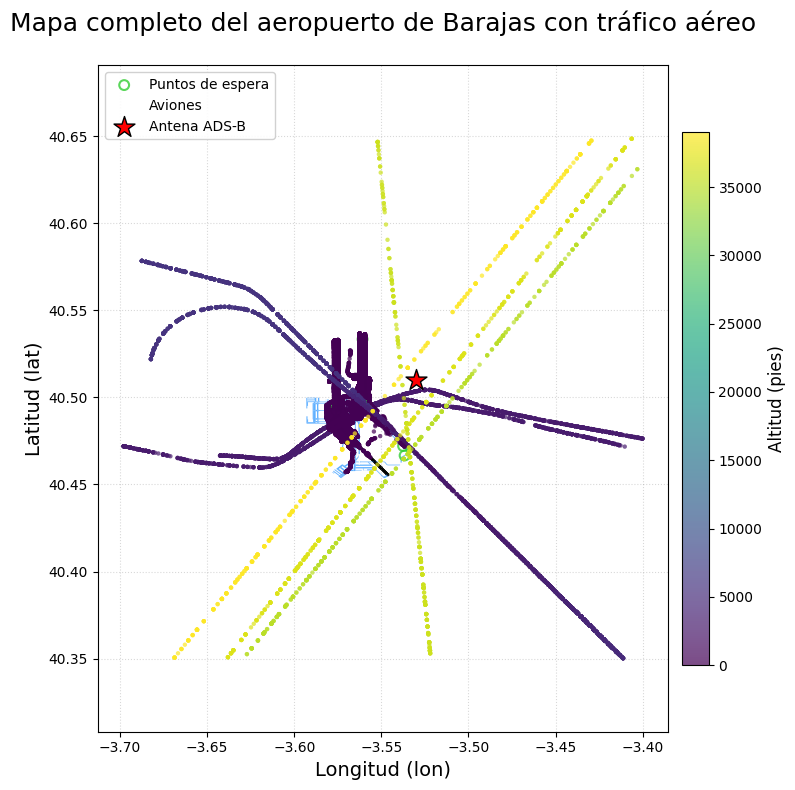

In [89]:
dia = 7
fecha = f"0{dia}-12-2024"
despegues = pd.read_parquet(f"../../data/filtrado/despegues/{fecha}.parquet")
aterrizajes = pd.read_parquet(f"../../data/filtrado/aterrizajes/{fecha}.parquet")
raros = pd.read_parquet(f"../../data/filtrado/raros/{fecha}.parquet")
showPlot(despegues)
showPlot(aterrizajes)
showPlot(raros)

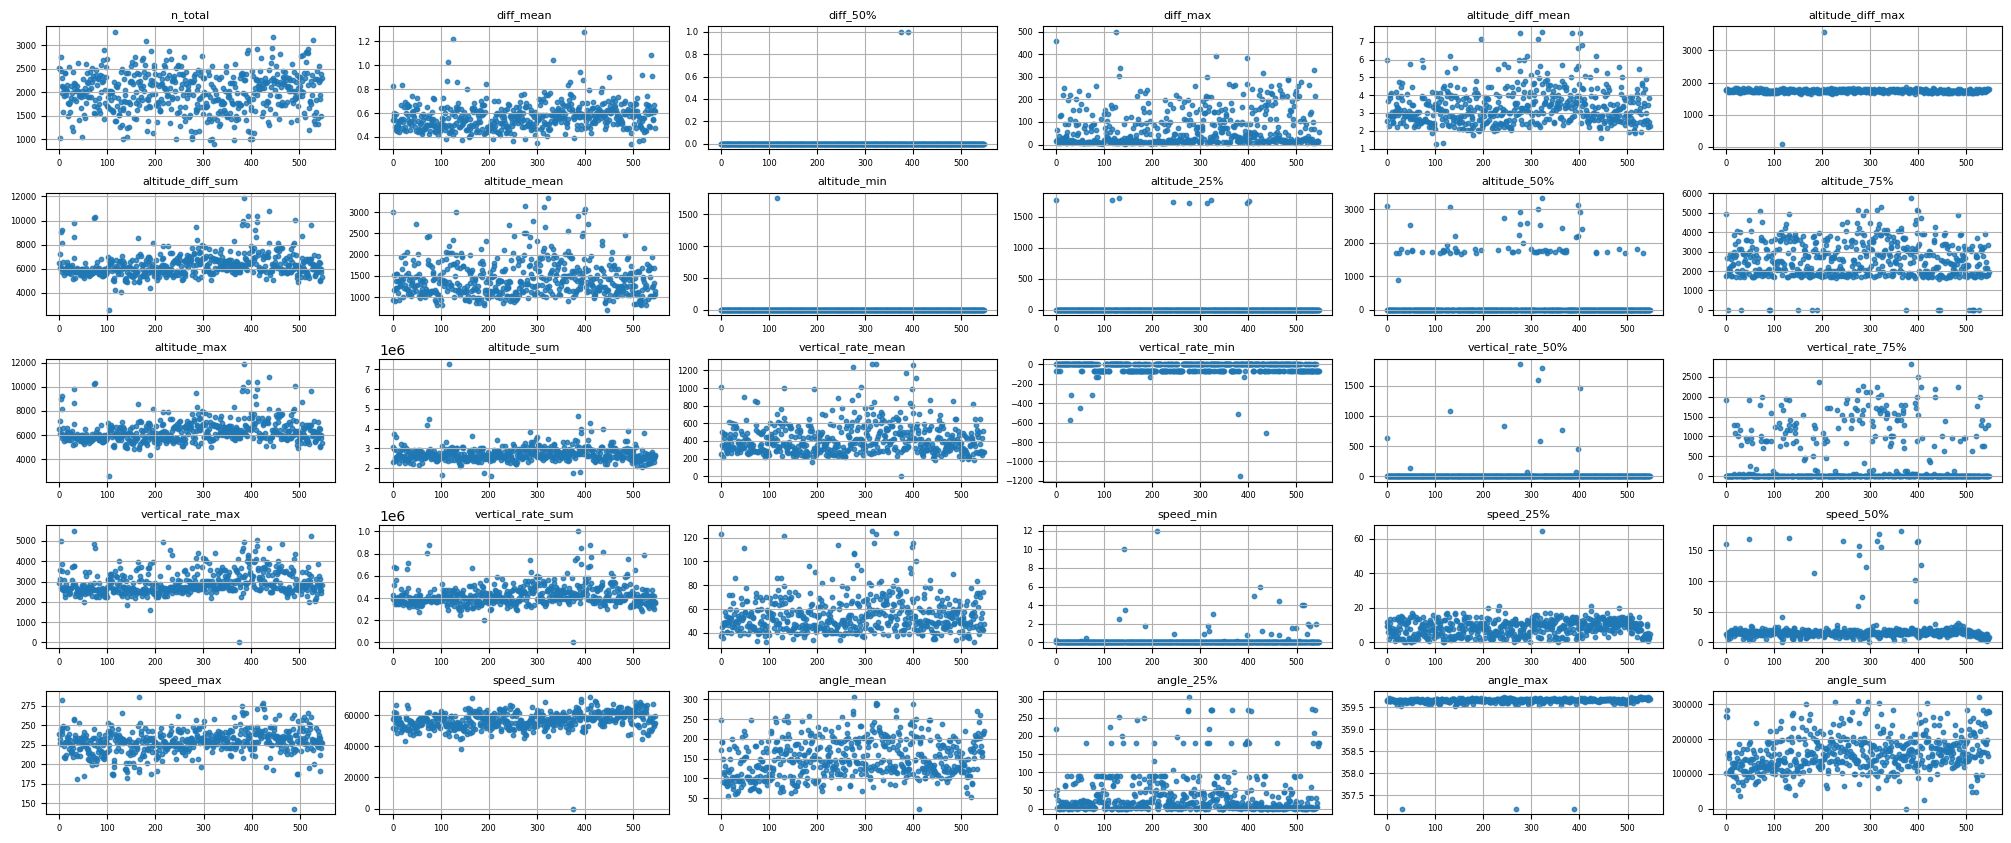

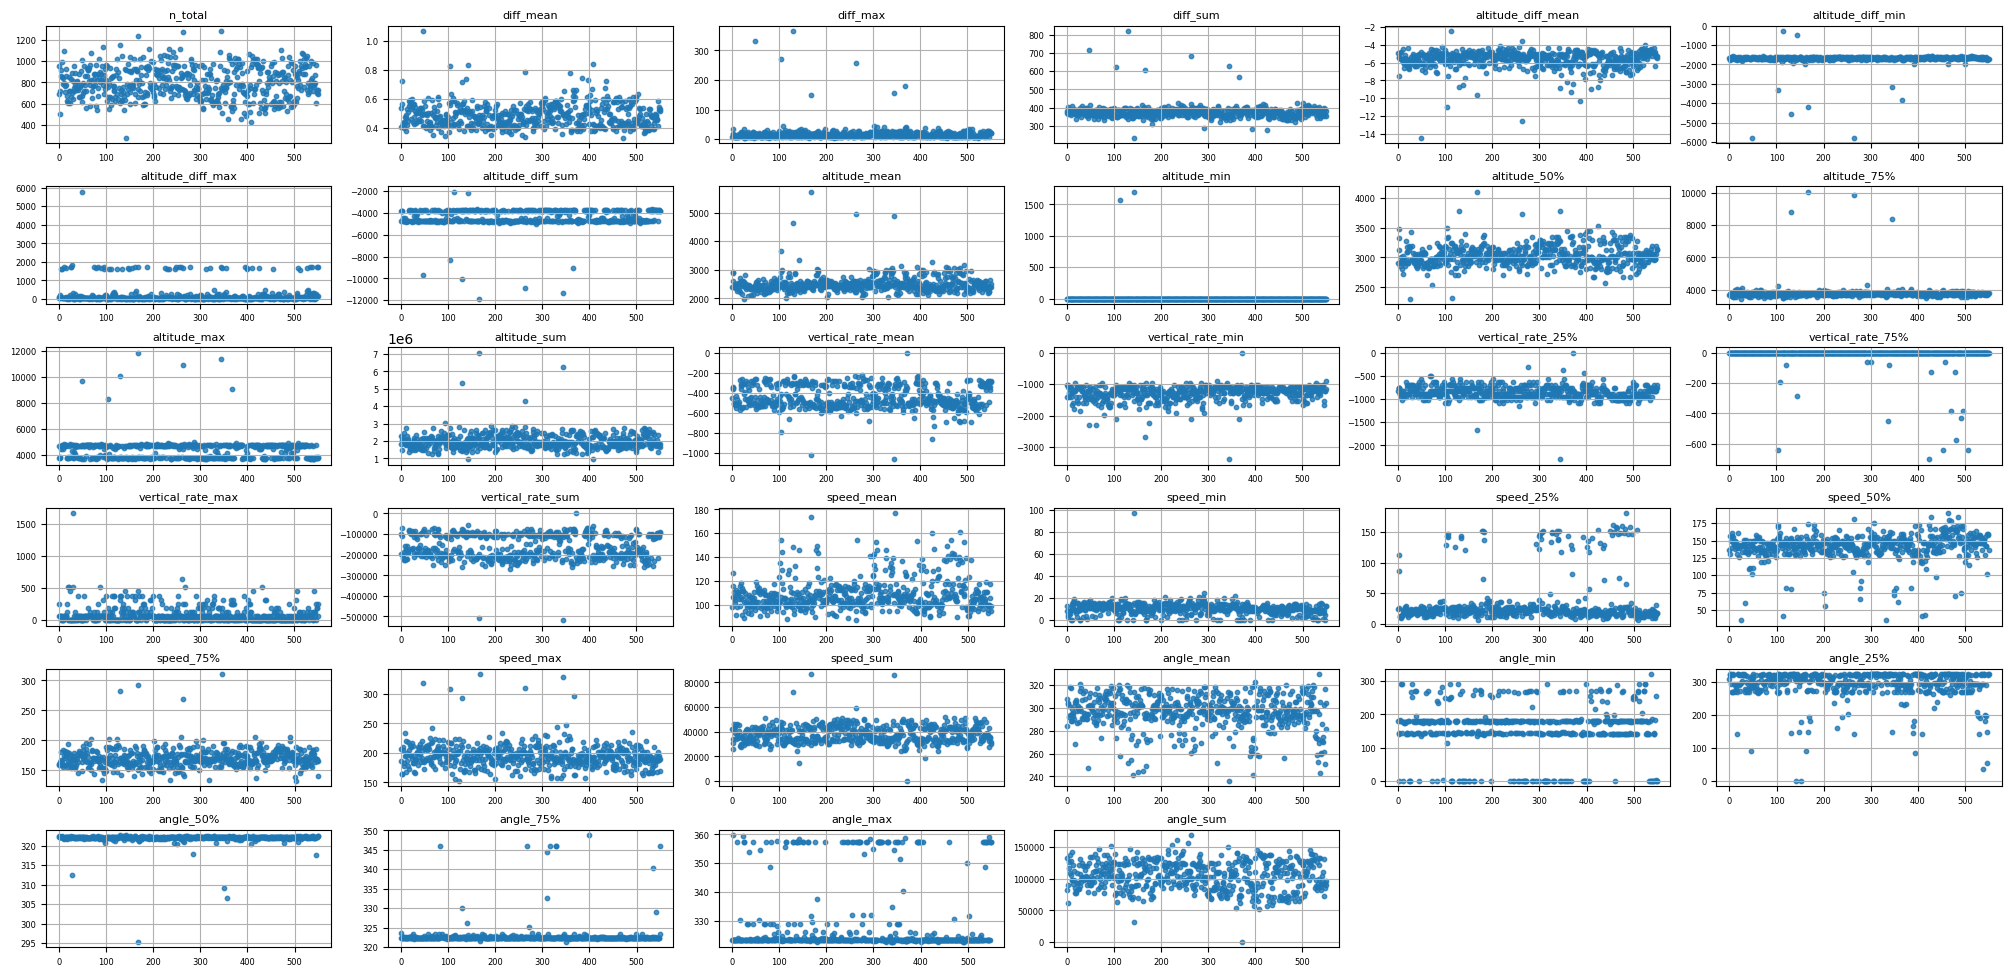

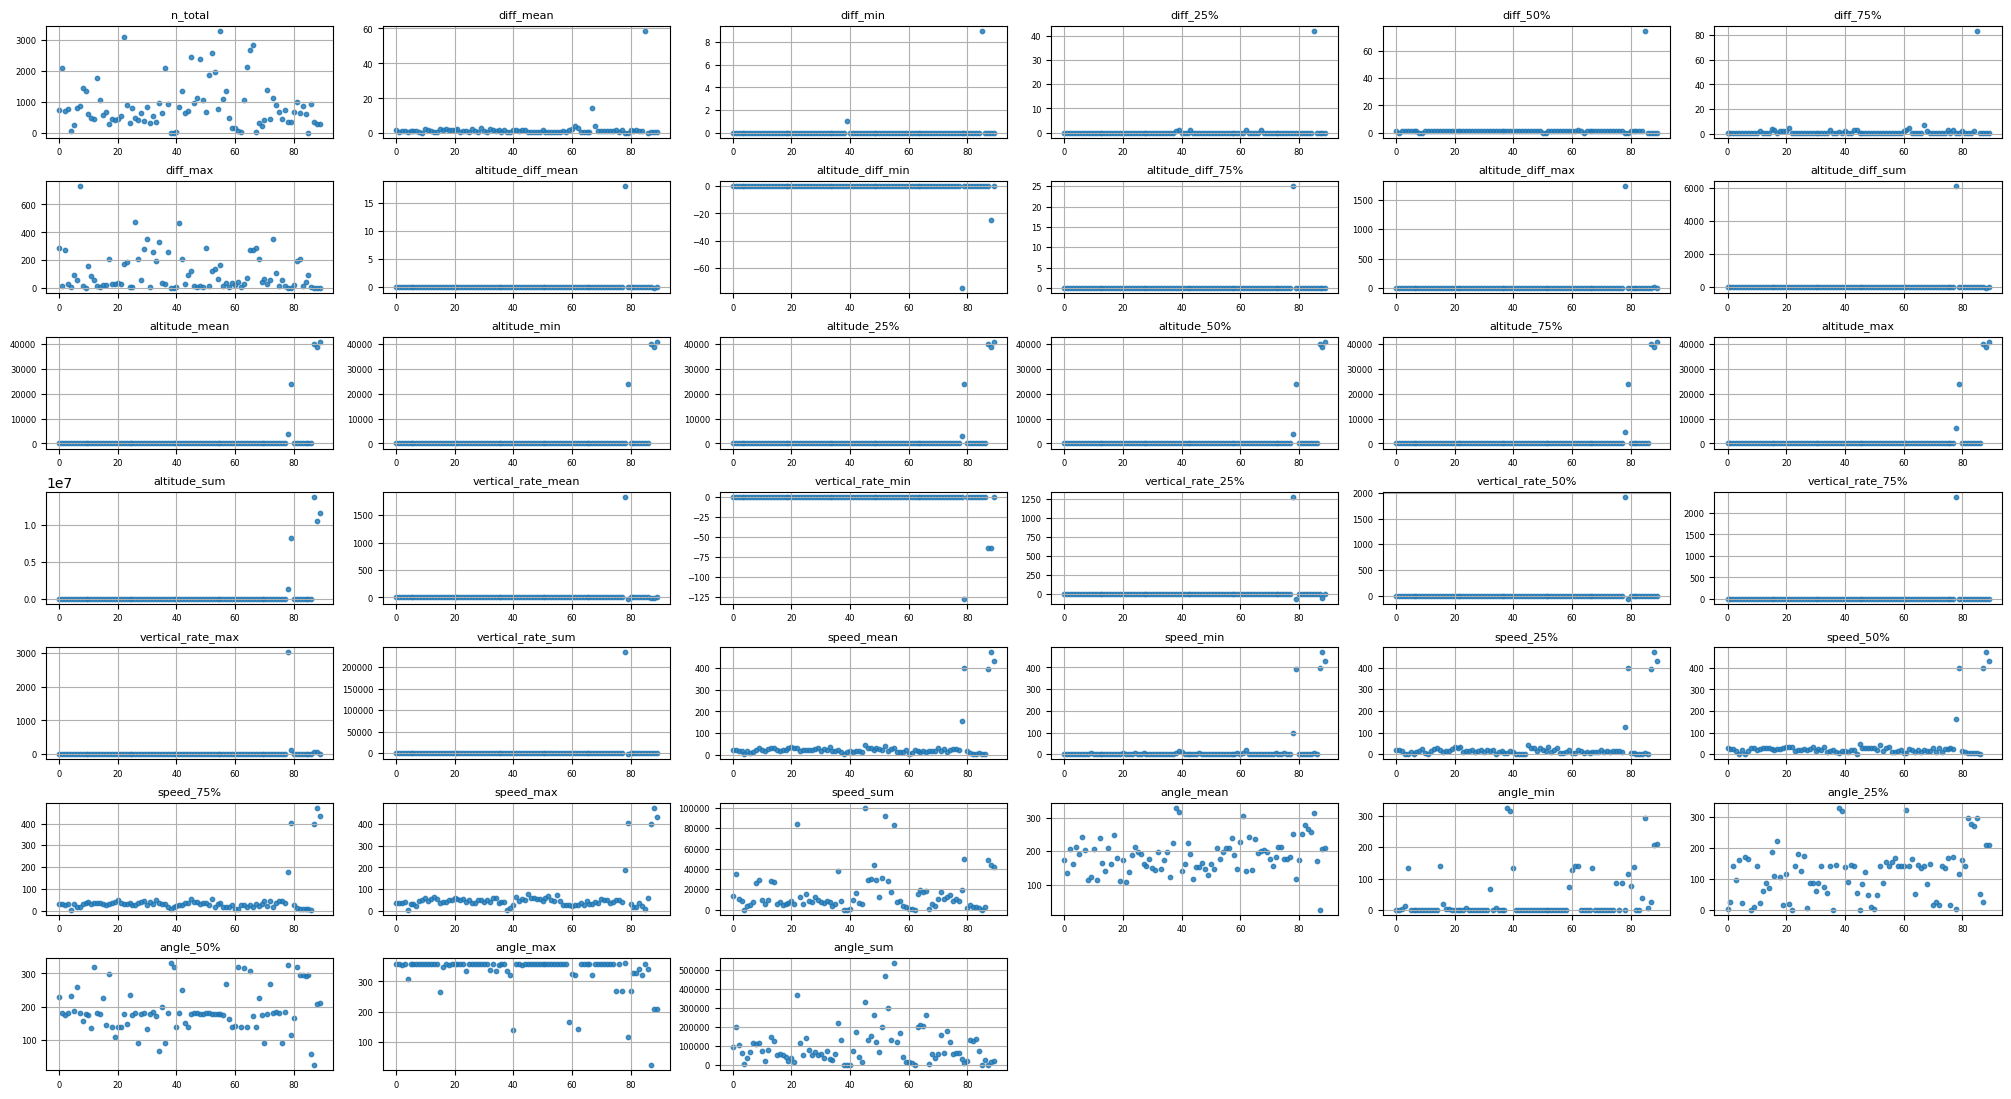

In [15]:
show_distribution(despegues)
show_distribution(aterrizajes)
show_distribution(raros)

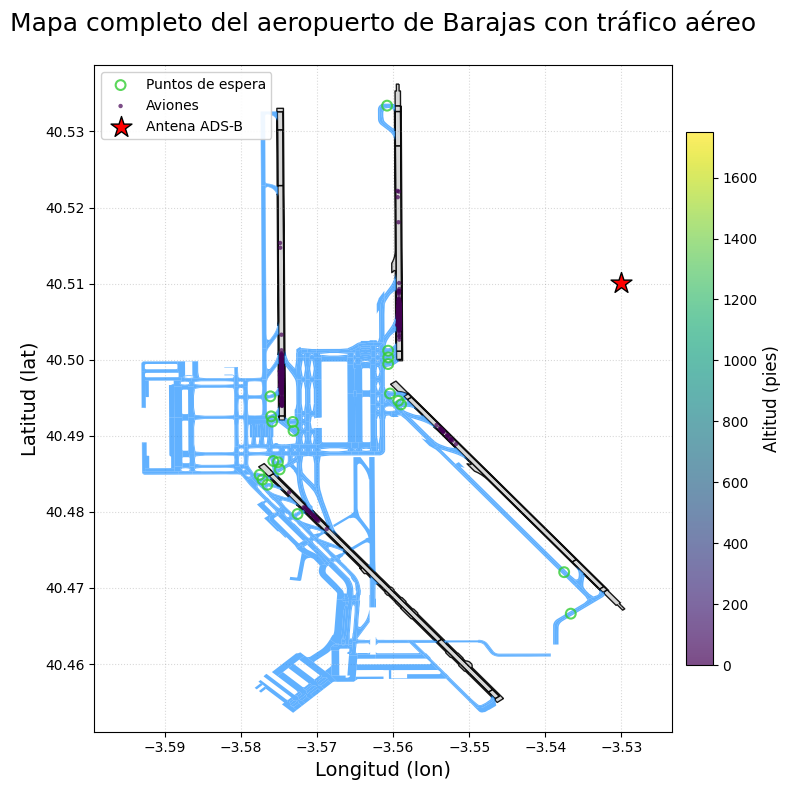

In [90]:
def showPlot(df):
    runways = gpd.read_file("./puntosespera/runways.geojson")
    taxiways = gpd.read_file("./puntosespera/taxiways.geojson")
    holding_points = gpd.read_file("./puntosespera/holding_points.geojson")

    fig, ax = plt.subplots(figsize=(8, 8))

    runways.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1, alpha=0.9, zorder=1, label='Pistas')
    taxiways.plot(ax=ax, color='dodgerblue', linewidth=1, alpha=0.7, zorder=2, label='Calles de rodaje')
    holding_points.plot( ax=ax, marker='o', markersize=50, facecolor='none', edgecolor='limegreen', linewidth=1.5, alpha=0.8, zorder=3, label='Puntos de espera')
    scatter = ax.scatter(df['lon_despegue_onground'], df['lat_despegue_onground'], c=df['altitude'], cmap='viridis', alpha=0.7, s=10, edgecolors='none', zorder=4, label='Aviones')
    ax.scatter(-3.5300000, 40.5100278, s=250, marker='*', color='red', edgecolor='black', linewidth=1, zorder=5, label='Antena ADS-B')

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Altitud (pies)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    # ax.set_xlim(-3.60, -3.50)
    # ax.set_ylim(40.45, 40.55)
    ax.set_title("Mapa completo del aeropuerto de Barajas con tráfico aéreo", fontsize=18, pad=25)
    ax.set_xlabel("Longitud (lon)", fontsize=14)
    ax.set_ylabel("Latitud (lat)", fontsize=14)
    ax.grid(alpha=0.3, linestyle=':', color='gray')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import geopandas as gpd
dfs = []
for i in range(1, 8):
    temp = pd.read_parquet(f"../../data/filtrado/despegues/0{i}-12-2024.parquet")
    temp["day"] = temp["ts"].dt.day
    dfs.append(temp)
aux = pd.concat(dfs).drop_duplicates(subset=["icao", "flight_id", "day"])
showPlot(aux)

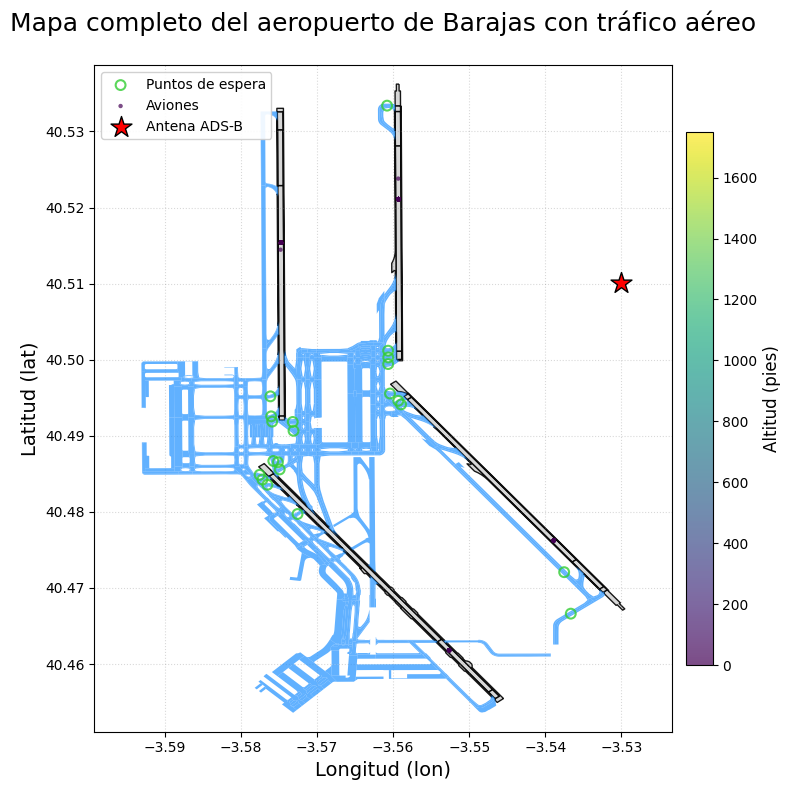

In [91]:
def showPlot(df):
    runways = gpd.read_file("./puntosespera/runways.geojson")
    taxiways = gpd.read_file("./puntosespera/taxiways.geojson")
    holding_points = gpd.read_file("./puntosespera/holding_points.geojson")

    fig, ax = plt.subplots(figsize=(8, 8))

    runways.plot(ax=ax, edgecolor='black', facecolor='lightgray', linewidth=1, alpha=0.9, zorder=1, label='Pistas')
    taxiways.plot(ax=ax, color='dodgerblue', linewidth=1, alpha=0.7, zorder=2, label='Calles de rodaje')
    holding_points.plot( ax=ax, marker='o', markersize=50, facecolor='none', edgecolor='limegreen', linewidth=1.5, alpha=0.8, zorder=3, label='Puntos de espera')
    scatter = ax.scatter(df['lon_despegue'], df['lat_despegue'], c=df['altitude'], cmap='viridis', alpha=0.7, s=10, edgecolors='none', zorder=4, label='Aviones')
    ax.scatter(-3.5300000, 40.5100278, s=250, marker='*', color='red', edgecolor='black', linewidth=1, zorder=5, label='Antena ADS-B')

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Altitud (pies)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    # ax.set_xlim(-3.60, -3.50)
    #ax.set_ylim(40.45, 40.55)
    ax.set_title("Mapa completo del aeropuerto de Barajas con tráfico aéreo", fontsize=18, pad=25)
    ax.set_xlabel("Longitud (lon)", fontsize=14)
    ax.set_ylabel("Latitud (lat)", fontsize=14)
    ax.grid(alpha=0.3, linestyle=':', color='gray')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import geopandas as gpd
dfs = []
for i in range(1, 8):
    temp = pd.read_parquet(f"../../data/filtrado/despegues/0{i}-12-2024.parquet")
    temp["day"] = temp["ts"].dt.day
    dfs.append(temp)
aux = pd.concat(dfs).drop_duplicates(subset=["icao", "flight_id", "day"])
showPlot(aux)

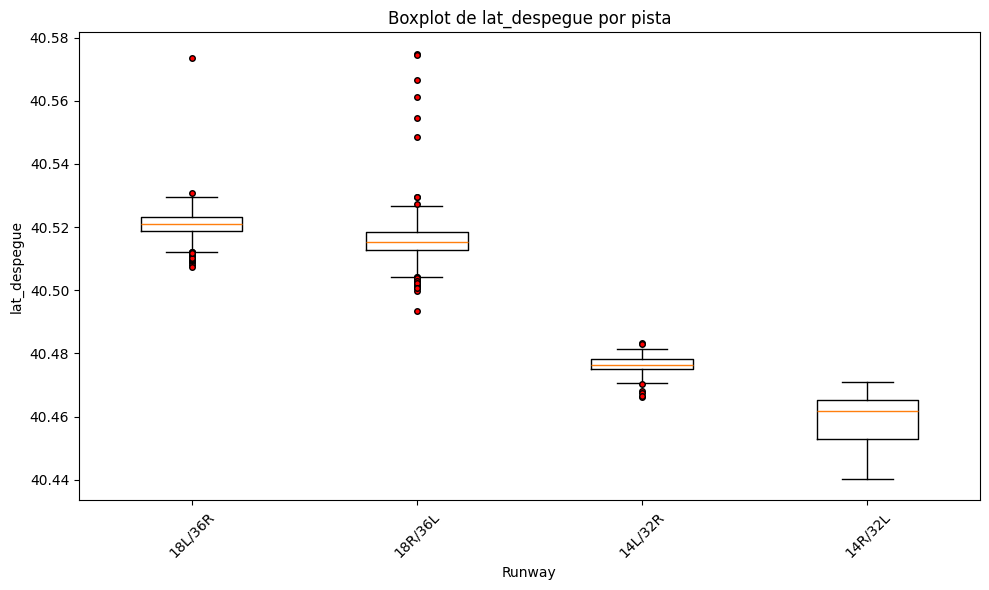

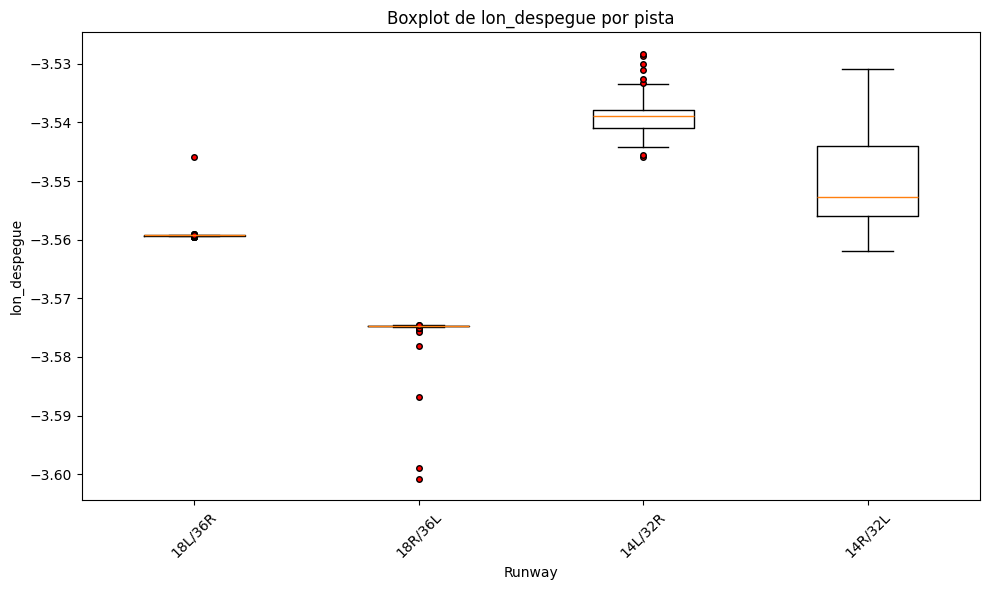

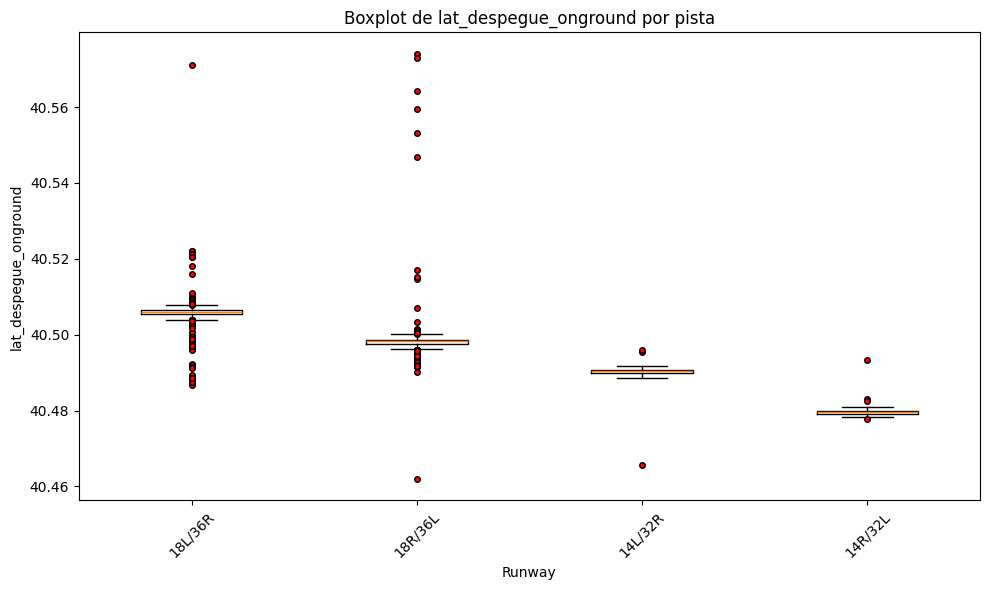

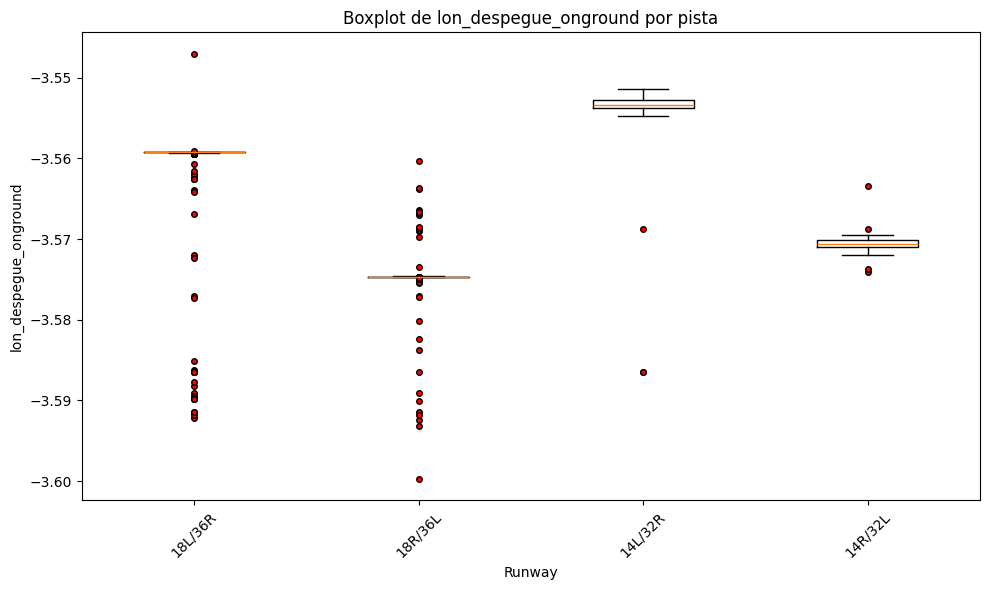

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

dfs = []
for i in range(1, 8):
    temp = pd.read_parquet(f"../../data/filtrado/despegues/0{i}-12-2024.parquet")
    temp["day"] = temp["ts"].dt.day
    dfs.append(temp)
aux1 = pd.concat(dfs).drop_duplicates(subset=["icao", "flight_id", "day"])
cols = [ 'lat_despegue', 'lon_despegue', 'lat_despegue_onground', 'lon_despegue_onground']
runways = aux1['runway'].dropna().unique()
for col in cols:
    plt.figure(figsize=(10, 6))
    data = [ aux1.loc[aux1['runway'] == rw, col].dropna() for rw in runways ]
    plt.boxplot(data, labels=runways, showfliers=True, flierprops=dict(marker='o', markerfacecolor='red', markersize=4))
    plt.title(f'Boxplot de {col} por pista')
    plt.xlabel('Runway')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
